In [1]:
import sys

base_path = '/tf/eipi10/qbz95'
sys.path.append(base_path)

from qbz95 import config
import pandas as pd
config = config.get_config('jupyter')
pd.set_option('display.width', 1000)

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

# #当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload 

from qbz95.ml3.utils import util

2020-10-22 09:08:39,974: INFO: deployment = local_wechat
2020-10-22 09:08:39,975: INFO: base_path = /home/grid/eipi10/qbz95/qbz95
2020-10-22 09:08:39,976: INFO: data_path = /home/grid/eipi10/qbz95/data
2020-10-22 09:08:40,382: INFO: deployment = jupyter
2020-10-22 09:08:40,383: INFO: base_path = /tf/eipi10/qbz95/qbz95
2020-10-22 09:08:40,383: INFO: data_path = /tf/eipi10/qbz95/data


In [2]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


### 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset))
print(len(testset))


Files already downloaded and verified
Files already downloaded and verified
50000
10000


Let us show some of the training images, for fun.



torch.Size([32, 3, 32, 32])


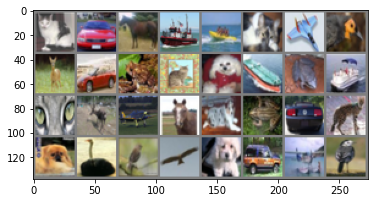

  cat   car horse  ship


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):

    img = img / 2 + 0.5     # unnormalize

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

###  2. Define   Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
print(len(params))
# print(params[0].size())  # conv1's .weight
for param in params:
    print(param.size())

10
torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
def train(net, criterion, trainloader, epoches=2, use_cuda=False):
    cuda_run = None
    if use_cuda and  torch.cuda.is_available():
        cuda_run = True
        net = net.cuda()
        criterion = criterion.cuda()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data            
            if cuda_run:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0


In [10]:
net = Net()
with util.TaskTime('training', True):
    train(net, criterion, trainloader, epoches=10)

2020-10-22 08:19:24,916: INFO: start training


[1,   500] loss: 0.575
[1,  1000] loss: 0.564
[1,  1500] loss: 0.517
[2,   500] loss: 0.470
[2,  1000] loss: 0.445
[2,  1500] loss: 0.424
[3,   500] loss: 0.407
[3,  1000] loss: 0.392
[3,  1500] loss: 0.382
[4,   500] loss: 0.368
[4,  1000] loss: 0.361
[4,  1500] loss: 0.357
[5,   500] loss: 0.343
[5,  1000] loss: 0.339
[5,  1500] loss: 0.338
[6,   500] loss: 0.329
[6,  1000] loss: 0.325
[6,  1500] loss: 0.314
[7,   500] loss: 0.311
[7,  1000] loss: 0.308
[7,  1500] loss: 0.305
[8,   500] loss: 0.295
[8,  1000] loss: 0.292
[8,  1500] loss: 0.293
[9,   500] loss: 0.283
[9,  1000] loss: 0.284
[9,  1500] loss: 0.280
[10,   500] loss: 0.272
[10,  1000] loss: 0.273
[10,  1500] loss: 0.274


2020-10-22 08:21:19,857: INFO: finish training [elapsed time: 114.94 seconds]


使用cuda计算，速度从140多秒变成100多秒。好像也没快多少啊. 如后文所说，是网络太小了，导致不明显。另外一个原因是后台看到大概使用了70%的cpu,aa00有20核，也就是说14个cpu参与了的计算。

In [10]:
net = Net()
with util.TaskTime('training', True):
    train(net, criterion, trainloader, epoches=20, use_cuda=True)   

2020-10-22 09:28:05,762: INFO: start training


[1,   500] loss: 2.293
[1,  1000] loss: 2.199
[1,  1500] loss: 2.065
[2,   500] loss: 1.881
[2,  1000] loss: 1.732
[2,  1500] loss: 1.665
[3,   500] loss: 1.591
[3,  1000] loss: 1.554
[3,  1500] loss: 1.535
[4,   500] loss: 1.493
[4,  1000] loss: 1.461
[4,  1500] loss: 1.440
[5,   500] loss: 1.402
[5,  1000] loss: 1.382
[5,  1500] loss: 1.377
[6,   500] loss: 1.327
[6,  1000] loss: 1.322
[6,  1500] loss: 1.314
[7,   500] loss: 1.287
[7,  1000] loss: 1.271
[7,  1500] loss: 1.253
[8,   500] loss: 1.217
[8,  1000] loss: 1.229
[8,  1500] loss: 1.210
[9,   500] loss: 1.182
[9,  1000] loss: 1.186
[9,  1500] loss: 1.178
[10,   500] loss: 1.153
[10,  1000] loss: 1.141
[10,  1500] loss: 1.139
[11,   500] loss: 1.098
[11,  1000] loss: 1.104
[11,  1500] loss: 1.122
[12,   500] loss: 1.063
[12,  1000] loss: 1.083
[12,  1500] loss: 1.081
[13,   500] loss: 1.037
[13,  1000] loss: 1.057
[13,  1500] loss: 1.043
[14,   500] loss: 1.025
[14,  1000] loss: 1.006
[14,  1500] loss: 1.022
[15,   500] loss: 0

2020-10-22 09:31:00,535: INFO: finish training [elapsed time: 174.77 seconds]


Let's quickly save our trained model:



In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



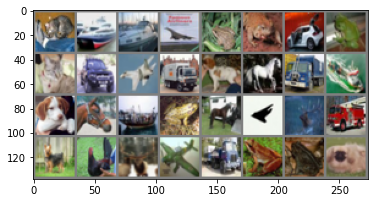

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [17]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 82 %
Accuracy of  bird : 46 %
Accuracy of   cat : 58 %
Accuracy of  deer : 63 %
Accuracy of   dog : 35 %
Accuracy of  frog : 69 %
Accuracy of horse : 69 %
Accuracy of  ship : 80 %
Accuracy of truck : 75 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_





Exercises
-------------------

Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number), see what kind of speedup you get

In [50]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [51]:
def train(net, criterion, trainloader, use_cuda=False):
    cuda_run = None
    if use_cuda and  torch.cuda.is_available():        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        cuda_run = True
        net = net.to(device)
#         criterion = criterion.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data            
            if cuda_run:
                inputs = inputs.to(device)
                labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

In [52]:
criterion = nn.CrossEntropyLoss()

In [53]:
net = Net()
with util.TaskTime('training', True):
    train(net, criterion, trainloader, use_cuda=True)   

2020-01-13 09:14:01,853: INFO: start training


[1,  2000] loss: 2.219
[1,  4000] loss: 1.831
[1,  6000] loss: 1.625
[1,  8000] loss: 1.546
[1, 10000] loss: 1.494
[1, 12000] loss: 1.438
[2,  2000] loss: 1.343
[2,  4000] loss: 1.322
[2,  6000] loss: 1.282
[2,  8000] loss: 1.238
[2, 10000] loss: 1.220
[2, 12000] loss: 1.212


2020-01-13 09:15:44,958: INFO: finish training [elapsed time: 103.11 seconds]


In [45]:
net = Net()
with util.TaskTime('training', True):
    train(net, criterion, trainloader, use_cuda=False)   

2020-01-13 09:08:19,044: INFO: start training


[1,  2000] loss: 2.161
[1,  4000] loss: 1.816
[1,  6000] loss: 1.639
[1,  8000] loss: 1.560
[1, 10000] loss: 1.489
[1, 12000] loss: 1.445
[2,  2000] loss: 1.360
[2,  4000] loss: 1.346
[2,  6000] loss: 1.293
[2,  8000] loss: 1.285
[2, 10000] loss: 1.265
[2, 12000] loss: 1.238


2020-01-13 09:10:48,281: INFO: finish training [elapsed time: 149.24 seconds]
